# **Load Dataset and Data Visualzation**

#### **Students**
André Silva, r20191226@novaims.unl.pt
Corssino Tchavana, 20220597@novaims.unl.pt
Diogo Silva, 20221393@novaims.unl.pt
Lucas Ferreira, 20220621@novaims.unl.pt


#### **Data Source**
Data Source:
https://www.kaggle.com/datasets/alessiocorrado99/animals10?select=raw-img

#### **Problem Definition**

This project aims to solve a Multi-Classification Problem by categorizing animal images and assigning them to one of the 10 animals. Deep Learning models will be used in image labeling to solve this problem.



#### **Summary**

This notebook's goal is to perform Data Visualization techniques to give insights about the dataset used in this project. 

First simple procedures were used to give a basic view of the dataset and to know what type of images are present in it. Then first dataset problem appeared, it is unbalanced.

The next techniques used were relating to Image Resolution, since the images could have different heights and widths, consequently, they also had diverse aspect ratios. It is important to refer that most images have a rectangular shape. To use the image dataset in the Neural Networks, the images will have to be resized. In order to mininmize distortion as much as possible the optimal ratio chosen (for reasons later specifieid, in section *Image Resolution*) was width = 1.4 * height. Due to hardware capability and RAM constraints the input size of the images will be 140,100.

Then some techniques were used to find images with borders, also to find the ones that were not JPEG and not RGB (to maintain homogeneity) and to discover duplicates.

Other analysis were made, such as caculating the average of each pixel per category, and creating an image from those average for each category - Despite the images having different number of animals, with different sizes, and colors, from different perspectives and the animals may be in different places of the images and have different backgrounds, it was possible to faintly see some of the animals of the category . Calculating the distribution of the RGB colors in each category - the distributions were similar for all categories.

The group also performed analysis of the blurriness and noise of the images. Analysis into compression artifacts was also tried.

Analysis into the texture and edges of each category.

The conclusion was the dataset does not have the best quality, despite it having an usability of 10 on Kaggle. 

**Warning - the code in sections Average pixel color per category, texture analysis and edges analysis takes a lot of time to run (1h+).**


### **Imports**

In [ ]:
import os
import time
import shutil
import random 
import zipfile
import hashlib
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from tqdm import tqdm

import cv2
from google.colab import drive, files
from google.colab.patches import cv2_imshow

from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow.keras import datasets, Sequential, layers, initializers, regularizers, optimizers, metrics 
from tensorflow.keras.preprocessing import image_dataset_from_directory

from sklearn import svm, decomposition
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.svm import OneClassSVM
from sklearn.utils import shuffle

from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

from skimage import color  
from skimage import feature
from shapely.geometry import Polygon
from skimage import measure
from imageio import imread
from skimage.color import rgb2gray
from skimage.feature import graycomatrix, graycoprops

### **Load Dataset**

The original Dataset was downloaded from kaggle and the category names were translated from Italian to English. The updated folder was updated to the google drive. From the drive mount the zipped dataset is grabbed from the google drive.


In [ ]:
# Set the machine
gdrive = True
# Set the connection string
path = "/content/drive/MyDrive/"
main_folder, training_folder = "10_animals.zip/", "train"
# If using Google Drive
if gdrive:
    # Setup drive
    drive.mount('/content/drive', force_remount=True)        
    # Transfer zip dataset to the current virtual machine
    t0 = time.time()
    shutil.copyfile(path + '10_animals.zip', '10_animals.zip')
    # Extract files
    zip_ = zipfile.ZipFile('10_animals.zip')
    zip_.extractall()
    zip_.close()
    print("File transfer completed in %0.3f seconds" % (time.time() - t0))
    path = ""

Mounted at /content/drive
File transfer completed in 21.699 seconds


# **Data Visualization**

In this notebook some studies will be done. In the first part of this notebook the studies will rely on the classes present in the dataset and on the other part the analysis will be regarding the instance itself and its properties, such as the size, the mode, its type.

To show a bit of what to expect from the database, 25 images are shown.

The following code selecet 25 random images of the dataset without repition, and plots them in a 5x5 grid.

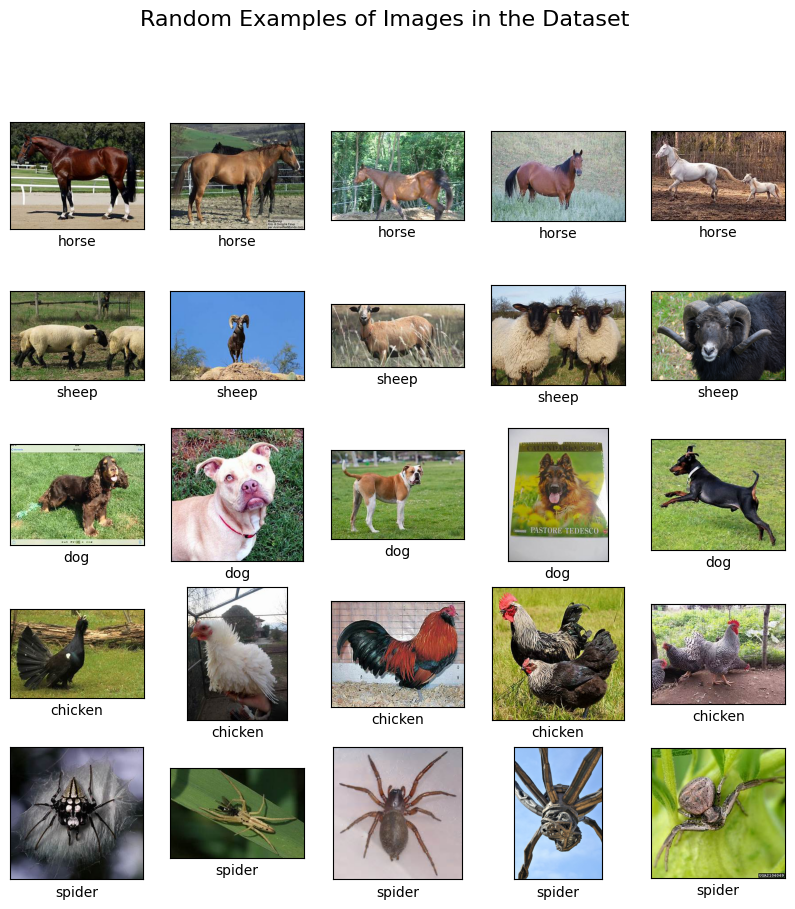

In [ ]:
# define the path to the dataset
path_to_dataset = path + training_folder

# define the list of categories
categories = os.listdir(path_to_dataset)

# set the number of images to show for each category
num_images = 5

# create a figure with subplots for each category
fig = plt.figure(figsize=(10,10))
fig.suptitle("Random Examples of Images in the Dataset", fontsize=16)

for i in range(5):
    for j in range(5):
        # get a random image from the category folder
        folder_name = os.listdir(path_to_dataset)[i]
        image_files = os.listdir(os.path.join(path_to_dataset, folder_name))
        image_file = os.path.join(path_to_dataset, folder_name, random.choice(image_files))
        
        # load the image and add it to the subplot
        image = plt.imread(image_file)
        num = i*num_images+j+1
        if num <= 25:
            plt.subplot(5, 5, num)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(image, cmap=plt.cm.binary)
            plt.xlabel(folder_name)
plt.show()



As it is percievable from the 25 images, the same animals are seen from different perspectives, may have different collors and may be in different places in the image, and may have more than 1 animal belonging to the same category.

### **Folder Composition**

Now there will be a study regarding the number of instances in each folder, to gain a broad perspective of the dataset.

Bar Chart to see the number of instances per folder:

The following code grabs the length of each of the 10 folders and then plots them as a bar chart.

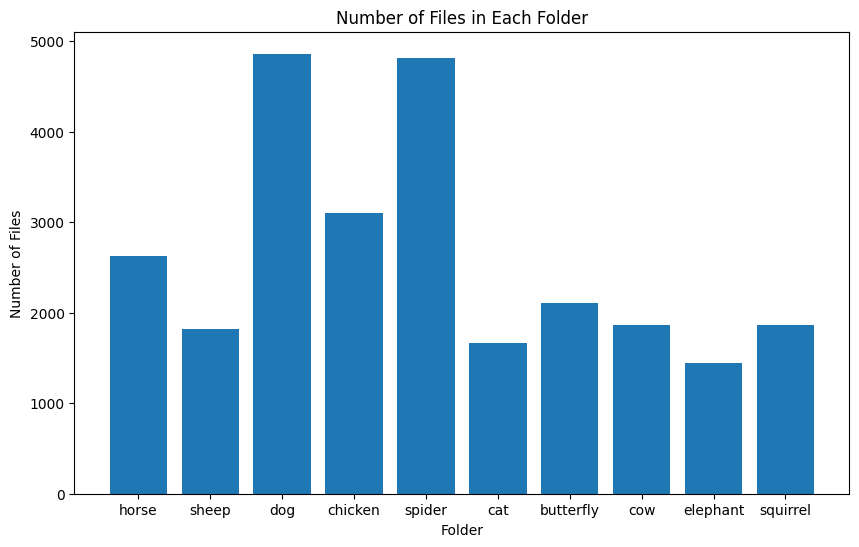

In [ ]:

# set the path to the folder containing the subfolders
path_to_folder = path + training_folder

# create an empty list to store the number of files in each folder
num_files = []
count=0
# loop through each folder in the directory
for folder in os.listdir(path_to_folder):
    # get the path to the folder
    folder_path = os.path.join(path_to_folder, folder)
    # count the number of files in the folder
    num_files_in_folder = len(os.listdir(folder_path))
    # append the number of files to the list
    num_files.append(num_files_in_folder)
    count=count + num_files_in_folder
# create a bar chart of the number of files in each folder
plt.figure(figsize=(10, 6))
plt.bar(range(len(num_files)), num_files)
plt.xticks(range(len(num_files)), os.listdir(path_to_folder))
plt.xlabel('Folder')
plt.ylabel('Number of Files')
plt.title('Number of Files in Each Folder')
plt.show()


There is evidence that the dataset in unbalanced, since there are classes with much more instances than others. There are two classse , dog and spider, with almost 5000 files and there are 6 classes where the number of instances is around 2000.

The group already produced a bar chart to have an idea of the number of each instances in each class, but what is the percentage of each class in all of the dataset?

To answer this question the group must produce a Pie chart and calculating percentages.

Pie chart of the proportions of the classes in the training folder:

The following code iterates through each category folder and makes sure each image is jpeg, if it is the path is counted. In the end there are 2 lists - the name of the categories and the corresponding count, which is plotted in a pie chart.

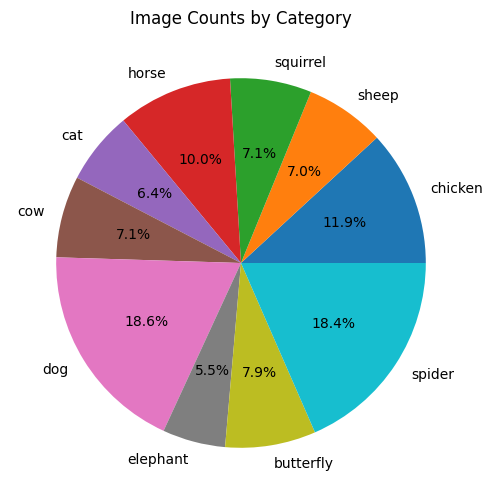

In [ ]:

# set the path to the training folder
path_to_dataset = os.path.join(path, training_folder)

# create empty lists to store the category names and image counts
categories = []
counts = []

# loop through each category folder
for folder in os.listdir(path_to_dataset):
    # create an empty list to store the file names
    file_names = []
    
    # loop through each file in the folder
    for file in os.listdir(os.path.join(path_to_dataset, folder)):
        # check if the file is a jpeg or jpg image
        if file.endswith('.jpeg') or file.endswith('.jpg'):
            # add the file name to the list
            file_names.append(file)
        
    # add the category name and image count to the respective lists
    categories.append(folder)
    counts.append(len(file_names))

# create a pie chart of the image counts
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(counts, labels=categories, autopct='%1.1f%%')
ax.set_title('Image Counts by Category')
plt.show()


From the Bar and Pie Charts it is visible that the dataset is **unbalanced**. Also, there are **26179** images in the dataset.

### **Image Resolution**

Plot **aspect ratios, height ,and width** of the images as histograms:

The following blocks of code iterates through each image gets their width and height and calculates the aspect ratio as width/height. The 3 values are then added to the corresponding list and then a histogram of each parameter is plotted.

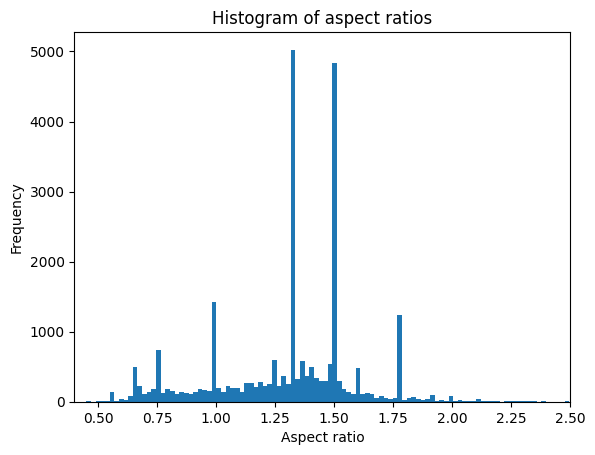

In [ ]:
# Initialize list to store images:
aspect_ratios = []
widths = []
heights = []

# Define path to the folder containing images
path_to_dataset = path + training_folder

# Loop through each class folder
for class_folder in os.listdir(path_to_dataset):
    # Get path to the class folder
    class_path = os.path.join(path_to_dataset, class_folder)
    # Loop through each file in the class folder
    for file in os.listdir(class_path):
        # Open the image and calculate its aspect ratio
        with Image.open(os.path.join(class_path, file)) as img:
            width, height = img.size
            aspect_ratio = width / height
            aspect_ratios.append(aspect_ratio)
            widths.append(width)
            heights.append(height)

# Plot the histogram of aspect ratios
plt.hist(aspect_ratios, bins=200)
plt.xlabel('Aspect ratio')
plt.ylabel('Frequency')
plt.title('Histogram of aspect ratios')
plt.xlim([0.4, 2.5])  # set the x-axis limits
plt.show()


The majority of the images appear to have rectangular dimensions. With a very significant percentage of the images having ratios of about 1.5 and 1.3.

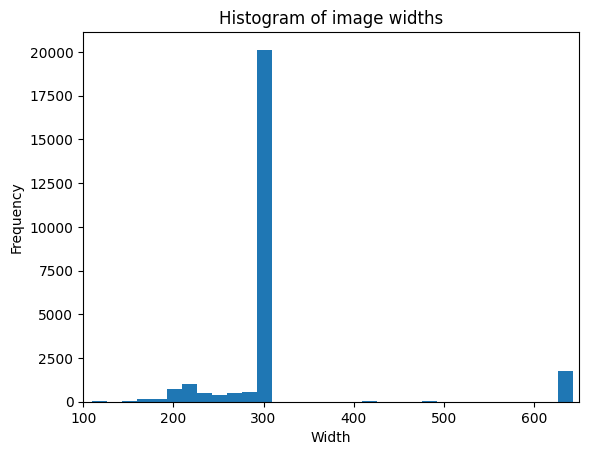

In [ ]:
# Plot the histogram of image widths
plt.hist(widths, bins=400)
plt.xlabel('Width')
plt.ylabel('Frequency')
plt.title('Histogram of image widths')
plt.xlim([100, 650])  # set the x-axis limits
plt.show()

The majority of the images present a width of 300 pixels.

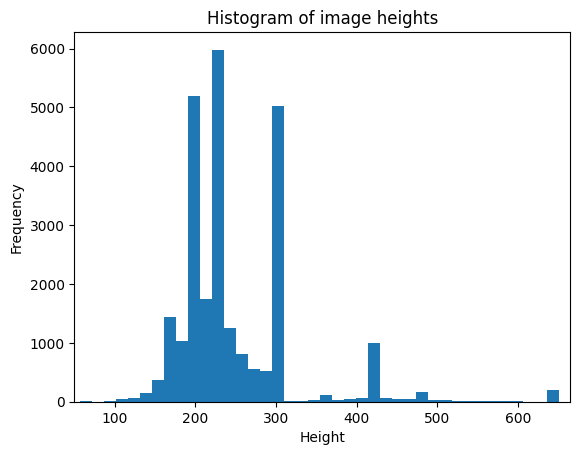

In [ ]:
# Plot the histogram of image heights
plt.hist(heights, bins=400)
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.title('Histogram of image heights')
plt.xlim([50, 665])  # set the x-axis limits
plt.show()

The majority of the imageshave a hieght between 150 and 320.



Now a study will be conducted regarding the size of the image, both width and height will be analysed at the same time.

The following code iterates through every image and grabs their dimemsions, after this it counts how many pictures have each size. For example 1 image has the size (x,z) and 200 images have the size (v,m).

In [ ]:
# Set the path to the directory containing the images
path_to_images = path + training_folder

# Create a dictionary to store the counts of images with each size
size_counts = {}

# Loop through each subdirectory in the images directory
for subdir in os.listdir(path_to_images):
    # Get the path to the subdirectory
    subdir_path = os.path.join(path_to_images, subdir)
    
    # Loop through each image file in the subdirectory
    for file_name in os.listdir(subdir_path):
        # Get the path to the image file
        file_path = os.path.join(subdir_path, file_name)
        
        # Open the image file using PIL
        with Image.open(file_path) as img:
            # Get the dimensions of the image
            img_size = img.size
            
            # Increment the count for the size of the image in the dictionary
            if img_size in size_counts:
                size_counts[img_size] += 1
            else:
                size_counts[img_size] = 1

# Print the counts for each image size
#for size, count in size_counts.items():
    #print(f"Size: {size}, Count: {count}")


Most common image sizes in the folder, and their number:

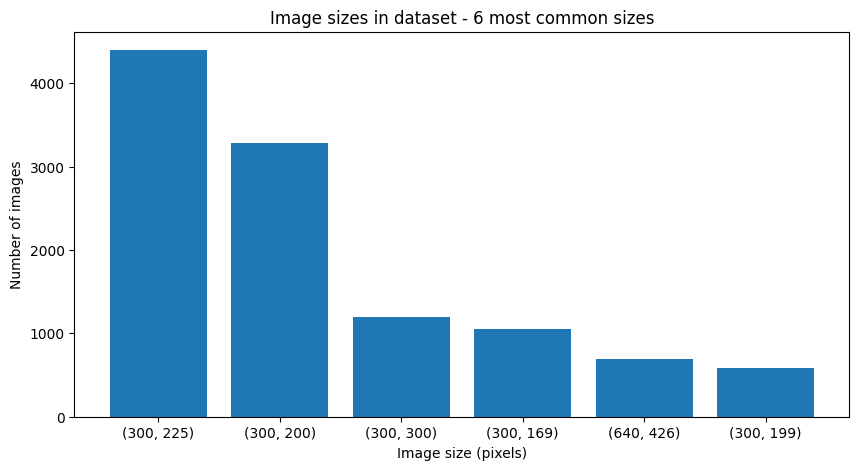

In [ ]:


# set the size of the resized images
IMG_SIZE = (128, 128)


# sort the sizes by count in descending order
sorted_sizes = sorted(size_counts.items(), key=lambda x: x[1], reverse=True)

# plot the bar chart of the 4 biggest bins
num_bins = 6
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(range(num_bins), [x[1] for x in sorted_sizes[:num_bins]], tick_label=[str(x[0]) for x in sorted_sizes[:num_bins]])
ax.set_xlabel('Image size (pixels)')
ax.set_ylabel('Number of images')
ax.set_title('Image sizes in dataset - 6 most common sizes')
plt.show()


The barchart confirms the previous charts from above, a significant percentage of the images have a rectangular shape.

Grouping of the sizes of the images by how many pictures there are in each size and plotting as a bar chart.

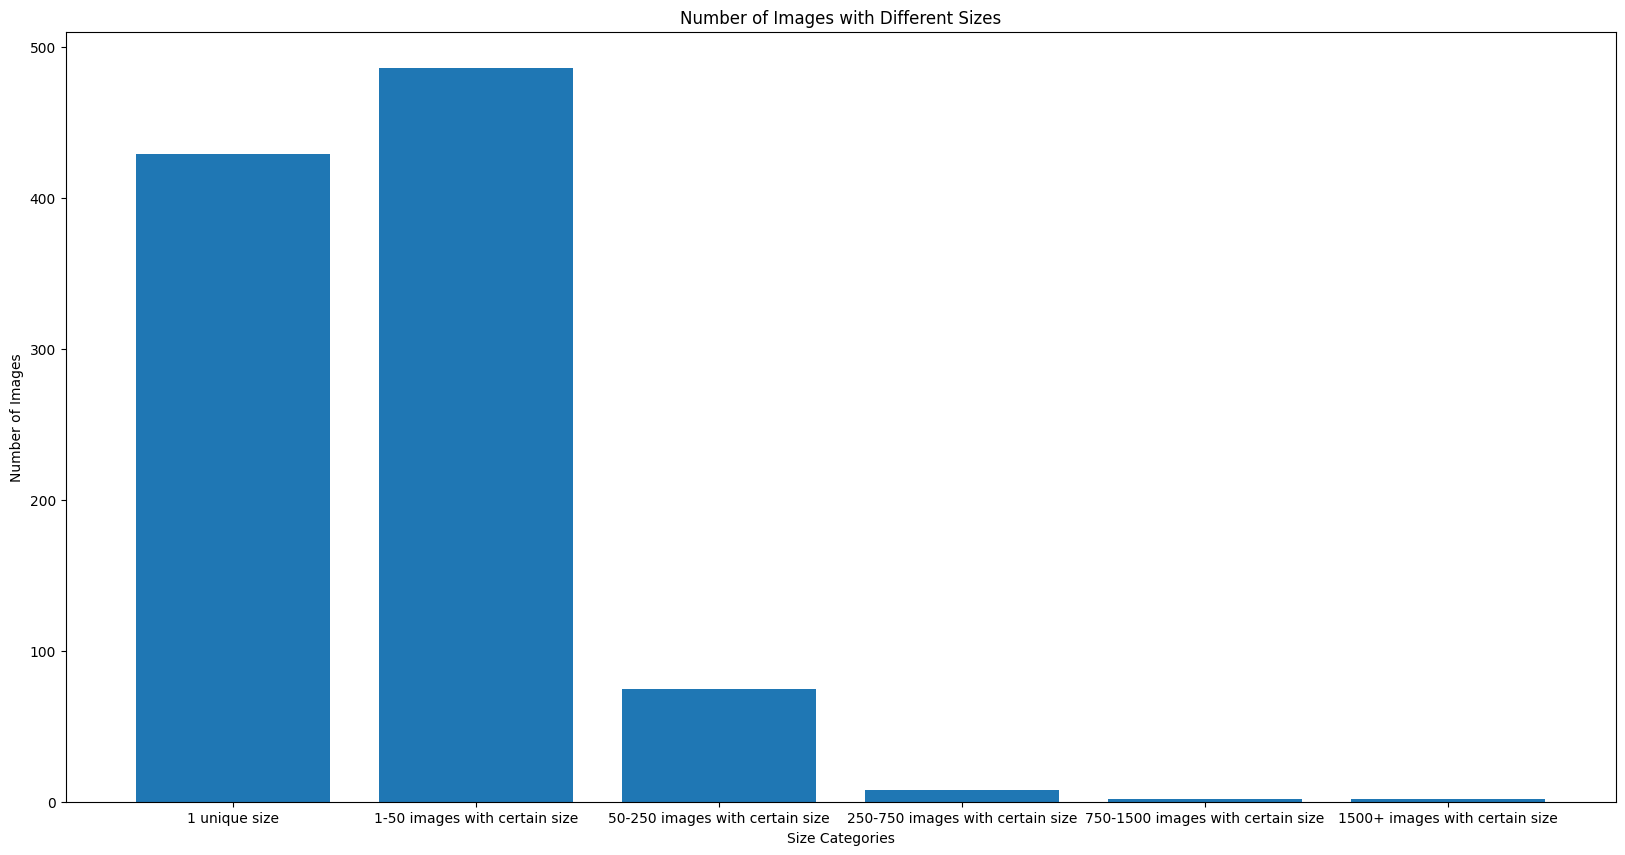

In [ ]:
# create a list to store the counts for each category
counts = [0, 0, 0, 0, 0, 0]

# loop through the dictionary and update the counts list
for size, count in size_counts.items():
    if count == 1:
        counts[0] += 1
    elif count <= 50:
        counts[1] += 1
    elif count <= 250:
        counts[2] += 1
    elif count <= 750:
        counts[3] += 1
    elif count <= 1500:
        counts[4] += 1
    else:
        counts[5] += 1

# create a list of labels for the x-axis
labels = ["1 unique size", "1-50 images with certain size", "50-250 images with certain size",
          "250-750 images with certain size", "750-1500 images with certain size", "1500+ images with certain size"]
plt.subplots(figsize=(20, 10))
# create a bar chart
plt.bar(labels, counts)


# set the title and x/y labels
plt.title("Number of Images with Different Sizes")
plt.xlabel("Size Categories")
plt.ylabel("Number of Images")

# display the chart
plt.show()


A considerable amount of images have a unique size, or almost unique size.
But from the histograms and the dimensions of the most common sizes it is evident that the width is usually larger than the height.

To later use the images in the Neural Networks they will have to be resized to the same size. The size of the input images is important since it can affect several aspects of the CNN's performance:

* Model size: Larger input images will result in a larger number of parameters in the model. This can increase the model's memory requirements and training time, and may make it more prone to overfitting.

* Feature extraction: Smaller images may not contain enough detail to capture all the relevant features, while larger images may contain too much detail, making it harder for the CNN to extract useful features. This can affect the CNN's ability to accurately classify or recognize objects in the images.

* Spatial resolution: The spatial resolution of the input images can affect the CNN's ability to accurately locate and classify objects. Higher resolution images can provide more detailed information about object boundaries and spatial relationships, while lower resolution images may obscure important details.

In general, it is a good practice to use input images that are as large as possible without exceeding the memory limitations of the hardware. This will allow the CNN to capture as much relevant information as possible, while minimizing the risk of overfitting. However, it is also important to balance this with the training time and computational resources required to train the model.







Resizing the images may cause distortion and affect factors such as blurriness, resolution and noise so it is important to try and mantain the aspect ratio as much as possible. Considering the aspect ratio histogram and the 2 most common sizes the ratio decided is width=1.4 x height.

Considering the capabilities of the hardware such as RAM constraints, and time constraints the input size will be (140, 100).

### **Borders**

Borders take away information from the images so the group searched for images with borders.

The following code loops through all the images in the dataset. Each image is loaded in grayscale and resized. If there is black border the pixel intensity will be 0 in the borders. The code checks if any of the 4 borders have a mean pixel intensity of 0. If the image has a border then a copy of the image with a yellow border using cv2.copyMakeBorder() is created. The number of images with borders and 25 five of the copied images are then shown.

In [ ]:
# Set the main folder path
main_folder = path + training_folder

# Set the border threshold
border_thresh = 10

# Create a list to store the images with borders
border_images = []

# Loop through the subfolders inside the main folder
for subfolder in os.listdir(main_folder):
    # Get the full path of the subfolder
    subfolder_path = os.path.join(main_folder, subfolder)
    # Loop through the images inside the subfolder
    for filename in os.listdir(subfolder_path):
        # Get the full path of the image
        img_path = os.path.join(subfolder_path, filename)
        # Load the image
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        # Resize the image to (140, 100)
        img = cv2.resize(img, (140, 100))
        # Get the height and width of the image
        h, w = img.shape[:2]
        # Check if any border is black
        top_border = np.mean(img[0:border_thresh, :]) == 0
        bottom_border = np.mean(img[h-border_thresh:h, :]) == 0
        left_border = np.mean(img[:, 0:border_thresh]) == 0
        right_border = np.mean(img[:, w-border_thresh:w]) == 0
        if top_border or bottom_border or left_border or right_border:
            #print(f"Image {img_path} has a border.")
            # Plot the image with a red border
            img_with_border = cv2.copyMakeBorder(img, border_thresh, border_thresh, border_thresh, border_thresh, cv2.BORDER_CONSTANT, value=(255, 0, 0))
            # Add the image to the list of border images
            border_images.append(img_with_border)

# Shuffle the list of border images
np.random.shuffle(border_images)

# Select the first 25 images
border_images_plot = border_images[:25]


In [ ]:
print('Number of images with borders:',len(border_images))

Number of images with borders: 40


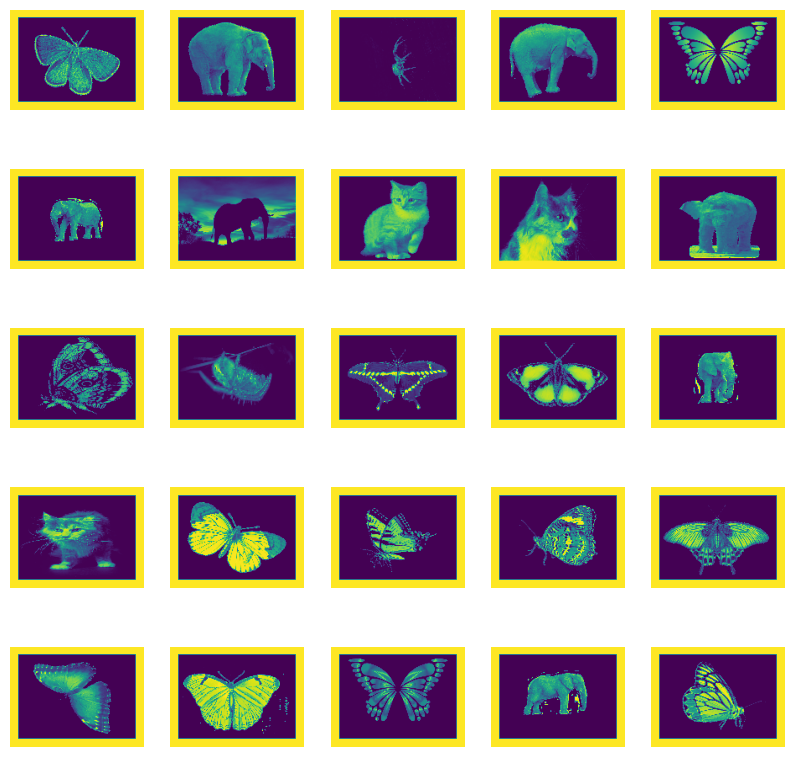

In [ ]:
# Display the images in a 5x5 grid
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
for i in range(5):
    for j in range(5):
        axs[i, j].imshow(border_images_plot[i*5+j])
        axs[i, j].axis('off')
plt.show()

### **Images type**

In order to ensure homogeneity between images and so that the code runs smoothly, the group will check what images are not JPEG (or jpg).

Reference: https://stackoverflow.com/questions/61844563/image-extension-jpg-or-png

The code loops through each image and checks if the images end in '.jpeg' or '.jpg' as they are the same team. If the image is not jpeg it will be counted in the variable exeptions.

In [ ]:
path_to_dataset= path + training_folder
exceptions = 0

# loop through each category folder
for folder in os.listdir(path_to_dataset):
    # create an empty list to store the file names
    file_names = []
    
    # loop through each file in the folder
    for file in os.listdir(os.path.join(path_to_dataset, folder)):
        # add the file name to the list
        file_names.append(file)
        
    # check the file extensions
    for file_name in file_names:
        extension = os.path.splitext(file_name)[1]
        if extension.lower() != '.jpg' and extension.lower() != '.jpeg':
            exceptions += 1
            
print(f"Number of files that are not JPEG: {exceptions}")

Number of files that are not JPEG: 64


### **Images mode**

In order to ensure homogeneity between images and so that the code runs smoothly, the group will check for the image mode of all images in each class:

The following code iterates trhouhg every image in each folder and check if the image mode is 'RGB', 'L' (grayscale), or other, counting them and then printing the number of images in each category with each image mode.

In [ ]:
# loop through each category folder
for folder in os.listdir(path_to_dataset):
    # create counters for different image modes
    num_rgb_images = 0
    num_grayscale_images = 0
    num_other_images = 0
    
    # loop through each file in the folder
    for file in os.listdir(os.path.join(path_to_dataset, folder)):
        # open the image
        img = Image.open(os.path.join(path_to_dataset, folder, file))
        
        # check the image mode
        if img.mode == 'RGB':
            num_rgb_images += 1
        elif img.mode == 'L':
            num_grayscale_images += 1
        else:
            num_other_images += 1
    
    # print the results for this category folder
    print(f"Category: {folder}")
    print(f"Number of RGB images: {num_rgb_images}")
    print(f"Number of grayscale images: {num_grayscale_images}")
    print(f"Number of other images: {num_other_images}")
    print()


Category: squirrel
Number of RGB images: 1862
Number of grayscale images: 0
Number of other images: 0

Category: spider
Number of RGB images: 4815
Number of grayscale images: 0
Number of other images: 0

Category: cat
Number of RGB images: 1663
Number of grayscale images: 0
Number of other images: 0

Category: sheep
Number of RGB images: 1820
Number of grayscale images: 0
Number of other images: 0

Category: butterfly
Number of RGB images: 2072
Number of grayscale images: 0
Number of other images: 0

Category: images_to_be_deleted
Number of RGB images: 12
Number of grayscale images: 0
Number of other images: 49

Category: cow
Number of RGB images: 1866
Number of grayscale images: 0
Number of other images: 0

Category: dog
Number of RGB images: 4863
Number of grayscale images: 0
Number of other images: 0

Category: horse
Number of RGB images: 2623
Number of grayscale images: 0
Number of other images: 0

Category: elephant
Number of RGB images: 1434
Number of grayscale images: 1
Number o

### **Duplicates**

The group will now check for duplicate images.

Resizing was done before checking because there could be instances of the same image but with different sizes, cropping of the same images.

Duplicate images have the same value of hash. The code works by using os.walk() to iterate through every image - only jpeg images are used. The images are resized before calculating the hash.
The hash of each image is computed by using cv2.imencode('.jpg', img)[1].tobytes() to convert the image into bytes and then calculates the MD5 hash of the bytes using hashlib.md5(). Each hash is added to hash_dict and checks if there hash already exists there.

In [ ]:

def get_duplicate_images(root_dir):
    """Finds and returns a list of duplicate images"""
    hash_dict = {}
    duplicate_images = []
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            # Check if file is an image file
            if filename.lower().endswith(('.jpg', '.jpeg')):
                image_path = os.path.join(dirpath, filename)
                # Load the image and resize it to (140, 100)
                img = cv2.imread(image_path)
                img = cv2.resize(img, (140, 100))
                # Compute the hash of the image bytes
                image_bytes = cv2.imencode('.jpg', img)[1].tobytes()
                image_hash = hashlib.md5(image_bytes).hexdigest()
                if image_hash in hash_dict:
                    # Duplicate found
                    duplicate_images.append((image_path, hash_dict[image_hash]))
                else:
                    # Add hash to dict
                    hash_dict[image_hash] = image_path
    return duplicate_images

# Usage example

root_dir = path + training_folder
duplicate_images = get_duplicate_images(root_dir)
if len(duplicate_images) > 0:
    print("Found duplicate images:")
    for image_pair in duplicate_images:
        print(image_pair[0], "is a duplicate of", image_pair[1])
else:
    print("No duplicate images found")

No duplicate images found


### **Box Plots**

This code creates a box plot for each category folder in the directory. Each box plot will display the distribution of pixel values for each color channel (red, green, and blue) in the images in that folder. Only RGB JPEG images are used.

The following code wroks by Looping through each file in the folder, and if the file has the desired extension and is an RGB image, add the file name to the list of file names.

Load and resize all the images in the list of file names using OpenCV (cv2) library, and stack them vertically using np.vstack() function from NumPy.

Create a box plot of the pixel values for each channel (R, G, B) of the resized images using axs[row_idx, col_idx].boxplot() function, where row_idx and col_idx represent the row and column indices of the subplot, respectively.

Set the x-axis tick labels to 'R', 'G', and 'B' using axs[row_idx, col_idx].set_xticklabels() function, and set the title of the subplot to the name of the category folder.

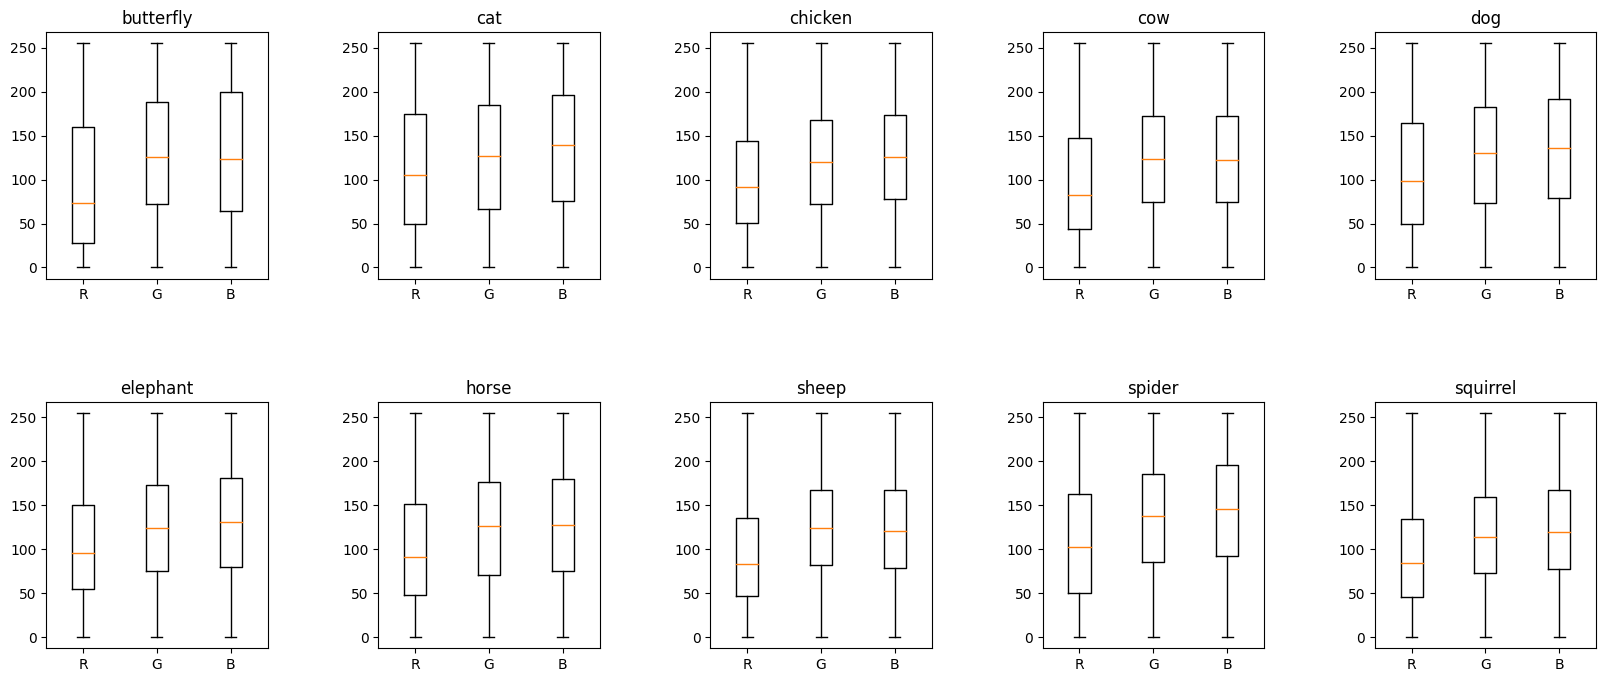

In [ ]:
# set the path to the dataset
path_to_dataset = path + training_folder

# create a list of file extensions to use
extensions = ['jpeg', 'jpg']

# set the desired image size
size = (140, 100)

# loop through each category folder
folders = sorted([f for f in os.listdir(path_to_dataset) if os.path.isdir(os.path.join(path_to_dataset, f))])
num_rows = 2
num_cols = 5
num_plots = num_rows * num_cols
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 8))

for i, folder in enumerate(folders):
    if i >= num_plots:
        break

    # create an empty list to store the file names
    file_names = []

    # loop through each file in the folder
    for file in os.listdir(os.path.join(path_to_dataset, folder)):
        # check if the file has the desired extension and is an RGB image
        if file.split('.')[-1].lower() in extensions:
            img = cv2.imread(os.path.join(path_to_dataset, folder, file))
            if img is not None and img.shape[-1] == 3:
                file_names.append(file)

    # load all the images, resize them, and stack them vertically
    images = []
    for file_name in file_names:
        # load the image
        img = cv2.imread(os.path.join(path_to_dataset, folder, file_name))

        # resize the image
        img_resized = cv2.resize(img, size)

        images.append(img_resized)

    images = np.vstack(images)

    # create a box plot of the pixel values for each channel
    row_idx = i // num_cols
    col_idx = i % num_cols
    axs[row_idx, col_idx].boxplot(images.reshape(-1, images.shape[-1]))
    axs[row_idx, col_idx].set_xticklabels(['R', 'G', 'B'])
    axs[row_idx, col_idx].set_title(folder)

# adjust spacing between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.5)

# display the plot
plt.show()


There is no visible distinction of the distribution of the primary colors between categories.

### **Average pixel color per category**

Inspired by: https://towardsdatascience.com/exploratory-data-analysis-ideas-for-image-classification-d3fc6bbfb2d2

To get the average color per pixel per category from a dataset of images using Python, the general aproach is:

Iterate through each category and iterates thruogh each resized image in the dataset and converts it to a NumPy array.

For each category, create an empty NumPy array with the same dimensions as the images in the dataset.

For each pixel in the image, calculate the average value of the red, green, and blue (RGB) channels.

Assign the average RGB value to the corresponding pixel in the category's NumPy array.

Once all images in the dataset have been processed, calculate the mean of each pixel value in each category's NumPy array. This will give return the average color per pixel per category. Which is then converted back to images.

Only JPEG RGB images are used, and the images are resized before using.

Average color for butterfly: [270443.65336667 270241.97866667 204667.44276667]
Average color for cat: [225669.28496667 211501.02276667 190133.3071    ]
Average color for chicken: [395633.6736 379237.3859 318425.8968]
Average color for cow: [233156.25626667 232996.14256667 188255.2578    ]
Average color for dog: [658752.14096667 631310.97953333 537411.00176667]
Average color for elephant: [188521.80896667 180300.83973333 154523.15686667]
Average color for horse: [337464.83273333 330199.19003333 276214.11513333]
Average color for sheep: [226338.98143333 227385.68166667 175143.82093333]
Average color for spider: [685768.17206667 652740.88096667 528755.7718    ]
Average color for squirrel: [231031.60243333 221183.93286667 178261.45986667]


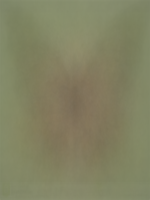

butterfly


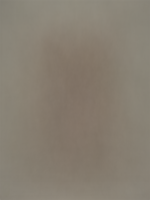

cat


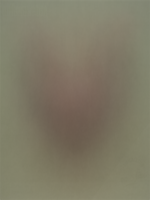

chicken


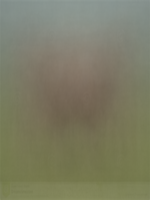

cow


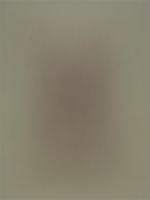

dog


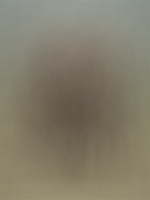

elephant


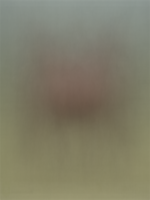

horse


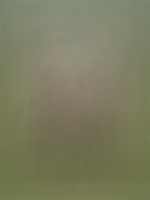

sheep


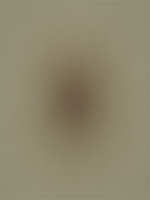

spider


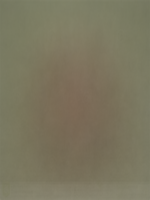

squirrel


In [ ]:
# Define the path to the dataset
path_to_dataset = path + training_folder

# Define the categories in the dataset
categories = ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']

# Define the dimensions of the images in the dataset
image_width = 150
image_height = 200

# Create empty NumPy arrays for each category
category_arrays = {}
for category in categories:
    category_arrays[category] = np.zeros((image_height, image_width, 3))

# Iterate through each image in the dataset
for category in categories:
    category_path = os.path.join(path_to_dataset, category)
    for filename in os.listdir(category_path):
        # Check if the file is a JPEG image and has 3 color channels
        if filename.endswith(".jpg") or filename.endswith(".jpeg"):
            image_path = os.path.join(category_path, filename)
            with Image.open(image_path) as image:
                if image.mode == 'RGB':
                    # Resize the image to the expected dimensions
                    image = image.resize((image_width, image_height))

                    image_array = np.array(image)

                    # Iterate through each pixel in the image
                    for y in range(image_height):
                        for x in range(image_width):
                            # Calculate the average RGB value for the pixel
                            r, g, b = image_array[y, x, :3]
                            avg_rgb = [r, g, b]

                            # Assign the average RGB value to the corresponding pixel in the category's NumPy array
                            category_arrays[category][y, x, :] += avg_rgb

# Calculate the mean of each pixel value in each category's NumPy array
for category in categories:
    category_mean = np.mean(category_arrays[category], axis=(0, 1))
    print(f'Average color for {category}: {category_mean}')

# Iterate through each category
for category in categories:
    # Create an empty array for the category's RGB values
    category_rgb = np.zeros((image_height, image_width, 3))

    # Iterate through each pixel in the category's NumPy array
    for y in range(image_height):
        for x in range(image_width):
            # Calculate the mean RGB value for the pixel
            pixel_mean = category_arrays[category][y, x, :] / len(os.listdir(os.path.join(path_to_dataset, category)))
            category_rgb[y, x, :] = pixel_mean

    # Create an Image object from the category's RGB array
    category_image = Image.fromarray(category_rgb.astype(np.uint8))

    # Display the category's image
    category_image.show()
    print(category)


Considering the images have different number of animals, in different colors, from different perspectives, and in different places in the images it would seem unreasonable to expect any pattern, but surprisingly, although blurry and faint it is possible to faintly make out animals such as sheep, horse, chicken, and butterfly.

___________________________

## **Analysis**

### **Texture**

Texture analysis is a technique used in image processing and computer vision to characterize the spatial arrangement and patterns of intensity values in an image. It involves extracting quantitative features from an image that describe its texture properties, such as smoothness, roughness, coarseness, and regularity.

Reference: https://github.com/scikit-image/scikit-image/blob/main/skimage/feature/texture.py

This is how the code works.

Define a function called get_texture_features(img) that takes an image img as input and calculates texture features using the gray-level co-occurrence matrix (GLCM). The function first converts the input image to an unsigned integer type and scales it to the range [0, 255]. Then it calculates the GLCM using the graycomatrix() function with a distance of 1, an angle of 0 (i.e., horizontal direction), and 256 levels. The symmetric=True and normed=True arguments ensure that the GLCM is symmetric and normalized. Finally, the function calculates several texture features using the graycoprops() function, namely contrast, homogeneity, energy, correlation, and angular second moment (ASM), and returns them as a dictionary.

Set the path to the parent folder containing the category folders using the parent_folder variable. This is the folder that contains the separate folders for each category, and each category folder contains the images for that category.

Initialize dictionaries to store the average texture features for each category, namely contrast_dict, homogeneity_dict, energy_dict, correlation_dict, and ASM_dict.

Loop through each category folder using the os.listdir() function, which returns a list of all the items in the directory specified by parent_folder.

For each category folder, get the path to the folder using os.path.join() and store it in the category_path variable.

Initialize a list called texture_features_list to store the texture features for each image in the category folder.

Loop through each image in the category folder using the os.listdir() function again, this time for the category_path. For each image file, check if it ends with '.jpg' or '.jpeg' to ensure that it is an RGB JPEG image.

If the image file is a valid RGB JPEG image, load the image using the skimage.io.imread() function and store it in the img variable. Check the number of dimensions of the image using the img.ndim attribute, and make sure it is a 3-dimensional image with 3 channels (i.e., RGB) using img.shape[2] == 3.

Convert the RGB image to grayscale using the skimage.color.rgb2gray() function and store it in the img_gray variable.

Calculate the texture features for the current image using the get_texture_features() function, and append the resulting dictionary of texture features to the texture_features_list.

If any valid images are found in the category folder, calculate the average texture features for the category by iterating through the texture features in the texture_features_list and taking the mean of each feature using np.mean(). Store the average texture features in the respective dictionaries contrast_dict, homogeneity_dict, energy_dict, correlation_dict, and ASM_dict with the category folder name as the key.

If no valid images are found in the category folder, print a message indicating that no valid images were found.

In [ ]:
def get_texture_features(img):
    # convert the image to an unsigned integer type
    img = (img * 255).astype('uint8')
    # calculate the co-occurrence matrix
    glcm = graycomatrix(img, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    # calculate the texture features
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    ASM = graycoprops(glcm, 'ASM')[0, 0]
    # return the texture features as a dictionary
    return {'contrast': contrast, 'homogeneity': homogeneity, 'energy': energy, 'correlation': correlation, 'ASM': ASM}
# set the path to the parent folder containing the category folders
parent_folder = path + training_folder

# initialize dictionaries to store the average texture features for each category
contrast_dict = {}
homogeneity_dict = {}
energy_dict = {}
correlation_dict = {}
ASM_dict = {}

# loop through each category folder
for category_folder in os.listdir(parent_folder):
    # get the path to the current category folder
    category_path = os.path.join(parent_folder, category_folder)

    # initialize lists to store the texture features for each image in the folder
    texture_features_list = []

    # loop through each image in the category folder
    for img_file in os.listdir(category_path):
        # get the path to the current image file
        img_path = os.path.join(category_path, img_file)

        # check if the file is an RGB JPEG image
        if img_file.endswith('.jpg') or img_file.endswith('.jpeg'):
            try:
                # load the image
                img = imread(img_path)
                if img.ndim == 3 and img.shape[2] == 3:
                    # convert the RGB image to grayscale
                    img_gray = rgb2gray(img)

                    # calculate the texture features for the current image
                    texture_features = get_texture_features(img_gray)

                    # append the texture features to the list
                    texture_features_list.append(texture_features)
            except:
                print(f"Error reading file: {img_file}")

    if len(texture_features_list) > 0:
        # calculate the average texture features for the category
        avg_texture_features = {}
        for feature_name in texture_features_list[0]:
            feature_values = [t[feature_name] for t in texture_features_list]
            avg_value = np.mean(feature_values)
            avg_texture_features[feature_name] = avg_value

        # store the average texture features in the respective dictionaries
        contrast_dict[category_folder] = avg_texture_features['contrast']
        homogeneity_dict[category_folder] = avg_texture_features['homogeneity']
        energy_dict[category_folder] = avg_texture_features['energy']
        correlation_dict[category_folder] = avg_texture_features['correlation']
        ASM_dict[category_folder] = avg_texture_features['ASM']

    else:
        print(f"No valid images found in category: {category_folder}")


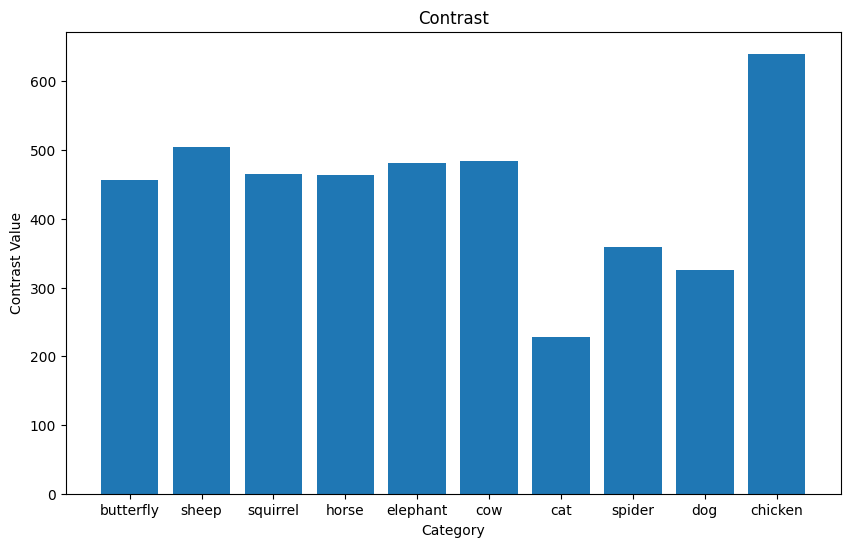

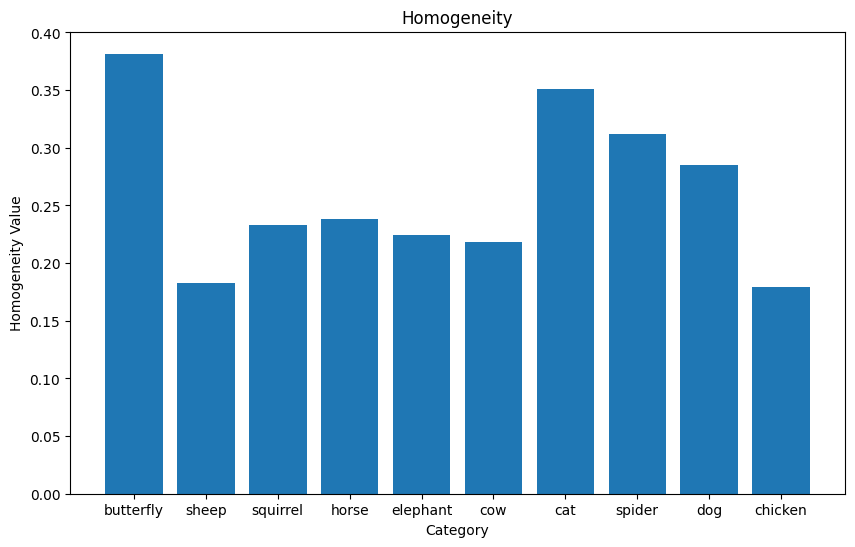

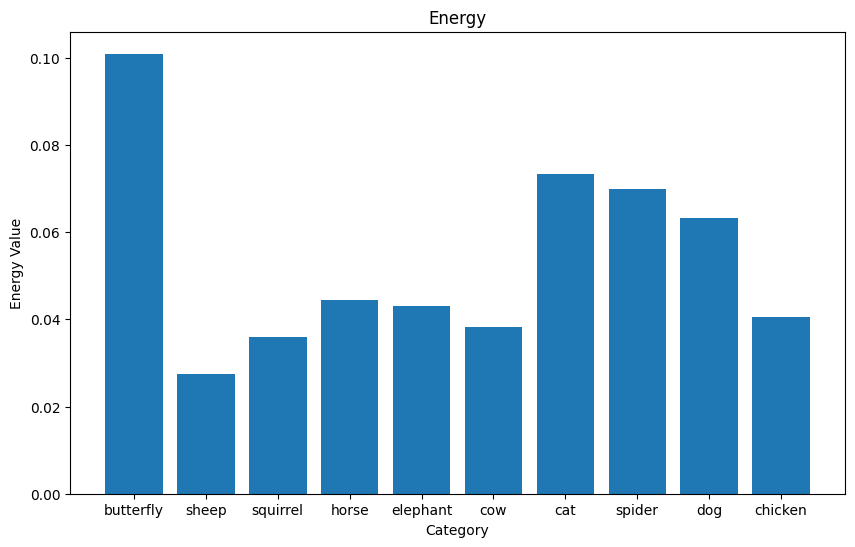

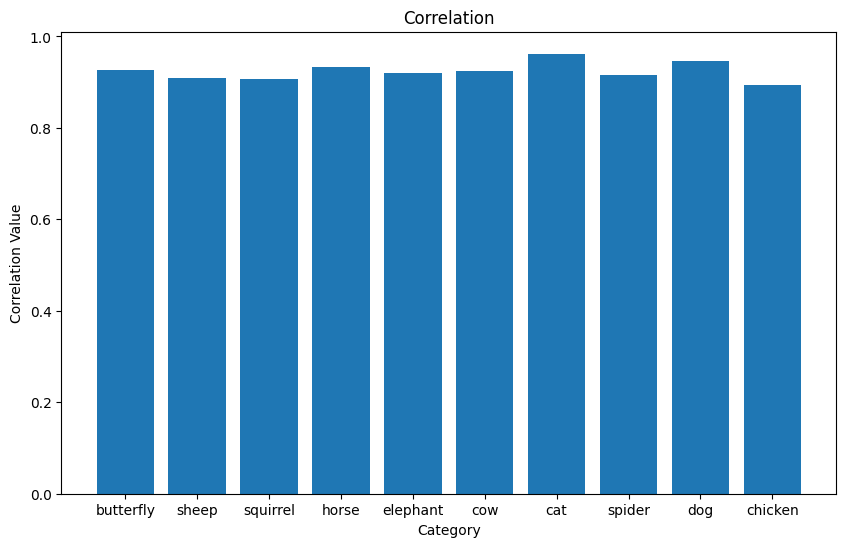

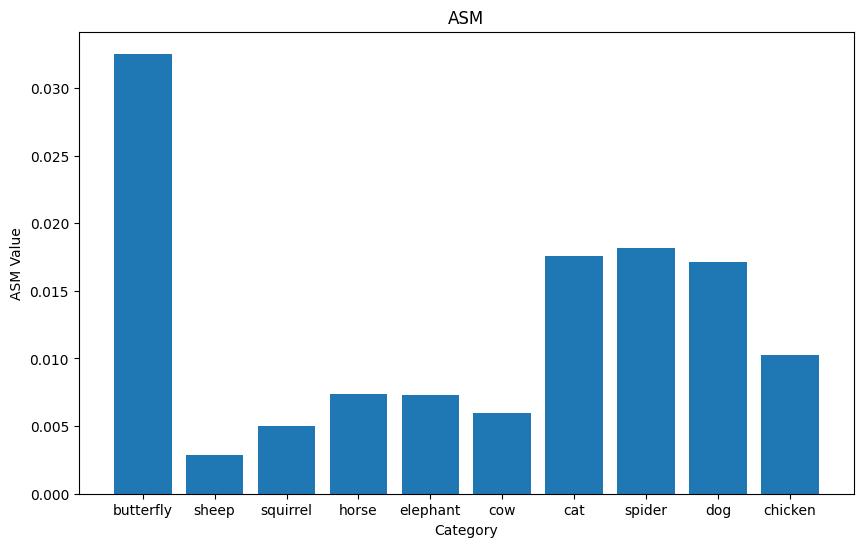

In [ ]:
# plot graph for contrast
plt.figure(figsize=(10, 6))  # set figure size
plt.bar(contrast_dict.keys(), contrast_dict.values())
plt.title("Contrast")
plt.xlabel("Category")
plt.ylabel("Contrast Value")

# plot graph for homogeneity
plt.figure(figsize=(10, 6))  # set figure size
plt.bar(homogeneity_dict.keys(), homogeneity_dict.values())
plt.title("Homogeneity")
plt.xlabel("Category")
plt.ylabel("Homogeneity Value")

# plot graph for energy
plt.figure(figsize=(10, 6))  # set figure size
plt.bar(energy_dict.keys(), energy_dict.values())
plt.title("Energy")
plt.xlabel("Category")
plt.ylabel("Energy Value")

# plot graph for correlation
plt.figure(figsize=(10, 6))  # set figure size
plt.bar(correlation_dict.keys(), correlation_dict.values())
plt.title("Correlation")
plt.xlabel("Category")
plt.ylabel("Correlation Value")

# plot graph for ASM
plt.figure(figsize=(10, 6))  # set figure size
plt.bar(ASM_dict.keys(), ASM_dict.values())
plt.title("ASM")
plt.xlabel("Category")
plt.ylabel("ASM Value")

plt.show()


Texture analysis seems to not be too relevant to the dataset since there is not a lot of distinction between values in each category. The biggest distinction would be the ASM values, but even then there are 7 (3 + 2 + 2) categories with almost the same values.

### **Edges**

Edges represent abrupt changes in intensity values and are often indicative of object boundaries or transitions between different regions in an image.

Reference: https://analyticsindiamag.com/image-feature-extraction-using-scikit-image-a-hands-on-guide/ & https://www.includehelp.com/python/edge-detection-of-image-using-opencv-cv2.aspx

* def get_edge_features(img):: This function takes an image img as input and returns a dictionary of edge features for that image. It first checks if the input image is grayscale, and if not, it converts the image to grayscale using the color.rgb2gray() function from the skimage library.

* edges = feature.canny(img_gray, sigma=1): The feature.canny() function from the skimage library is used to perform Canny edge detection on the grayscale image with a sigma (standard deviation) value of 1. This returns a binary edge map where edges are represented as white pixels (with intensity value of 1) and non-edges as black pixels (with intensity value of 0).

* perimeters = [np.sum(np.sqrt(np.sum(np.diff(c, axis=0) ** 2, axis=1))) for c in measure.find_contours(edges, 0.5)]: The measure.find_contours() function from the skimage library is used to find contours in the binary edge map at a threshold value of 0.5. The contours are then used to calculate the perimeter of each contour using the np.diff() and np.sqrt() functions from the numpy library. The sum of the calculated perimeters for all contours is stored in the perimeters list.

* return {'num_edges': len(perimeters)}: The function returns a dictionary with a single key-value pair where the key is 'num_edges' and the value is the length of the perimeters list, which represents the total number of edges detected in the image.

* parent_folder = path + training_folder: This sets the path to the parent folder containing the category folders where the input images are stored. The variable path is assumed to be previously defined and contains the path to the parent directory, and training_folder is the name of the subdirectory where the category folders are located.

* category_features = {}: This initializes an empty dictionary to store the average number of edges for each category.

* for category_folder in os.listdir(parent_folder):: This loops through each category folder in the parent folder.

* num_edges_list = []: This initializes an empty list to store the number of edges for each image in the current category.

* for img_file in os.listdir(category_path):: This loops through each image file in the current category folder.

* img_path = os.path.join(category_path, img_file): This constructs the full path to the current image file by joining the current category folder path with the image file name.

* if img_file.endswith('.jpg') or img_file.endswith('.jpeg'):: This checks if the current file is an image file with the extension '.jpg' or '.jpeg'.

* img = imread(img_path): The imread() function from a library (not specified in the code snippet) is used to read the image file into a numpy array img.

* edge_features = get_edge_features(img): The get_edge_features() function is called with the loaded image as input to extract the edge features for the image.

* num_edges_list.append(edge_features['num_edges']): The number of edges extracted from the image is appended to the num_edges_list.

* avg_num_edges = np.mean(num_edges_list): The average number of edges for the images in a category. It uses the np.mean() function from the NumPy library to calculate the mean (average) of the values in the num_edges_list list.

* num_edges_list is a list that stores the number of edges for each image in a category. The number of edges is calculated for each image using the get_edge_features() function, which takes an image as input and returns a dictionary of edge features. In this case, the only edge feature being calculated is the number of edges (num_edges) detected in the image.

* Once the num_edges_list is populated with the number of edges for all the images in a category, the np.mean() function is used to calculate the average of these values. The resulting average (avg_num_edges) is then stored in the category_features dictionary with the category folder name as the key.

* Finally, the code prints the average number of edges for each category by iterating through the category_features dictionary and displaying the category folder name along with its corresponding average number of edges using a formatted string.





In [ ]:
def get_edge_features(img):
    # check if the image is grayscale
    if img.ndim == 2:
        img_gray = img
    else:
        # convert the image to grayscale
        img_gray = color.rgb2gray(img)
    # apply Canny edge detection with sigma=1
    edges = feature.canny(img_gray, sigma=1)
    # calculate the perimeter of the edges
    perimeters = [np.sum(np.sqrt(np.sum(np.diff(c, axis=0) ** 2, axis=1))) for c in measure.find_contours(edges, 0.5)]
    # return the edge features as a dictionary
    return {'num_edges': len(perimeters)}


# set the path to the parent folder containing the category folders
parent_folder = path + training_folder

# initialize a dictionary to store the edge features for each category
category_features = {}

# loop through each category folder
for category_folder in os.listdir(parent_folder):
    # get the path to the current category folder
    category_path = os.path.join(parent_folder, category_folder)

    # initialize a list to store the number of edges for each image in the category
    num_edges_list = []

    # loop through each image in the category folder
    for img_file in os.listdir(category_path):
        #print(img_file)
        # get the path to the current image file
        img_path = os.path.join(category_path, img_file)

        # check if the file is an image
        if img_file.endswith('.jpg') or img_file.endswith('.jpeg'):
            # load the image
            img = imread(img_path)

            # calculate the edge features for the current image
            edge_features = get_edge_features(img)

            # append the number of edges to the num_edges_list
            num_edges_list.append(edge_features['num_edges'])

    # calculate the average number of edges for the category
    avg_num_edges = np.mean(num_edges_list)

    # store the average number of edges for the category in the category_features dictionary
    category_features[category_folder] = avg_num_edges
    #print(f"Avg. num edges: {category_features}")

# print the average number of edges for each category
for category_folder in category_features:
    print(f"Category: {category_folder}",f"Avg. num edges: {category_features[category_folder]}")

<ipython-input-8-f5619d278b98>:49: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(img_path)


Category: butterfly Avg. num edges: 1725.4517374517375
Category: sheep Avg. num edges: 3394.978021978022
Category: squirrel Avg. num edges: 1875.8829215896885
Category: horse Avg. num edges: 1753.5592832634388
Category: elephant Avg. num edges: 3380.058414464534
Category: cow Avg. num edges: 1769.478563772776
Category: cat Avg. num edges: 4349.496100779844
Category: spider Avg. num edges: 1729.386179705333
Category: dog Avg. num edges: 1557.1172115977793
Category: chicken Avg. num edges: 2392.2424144609427


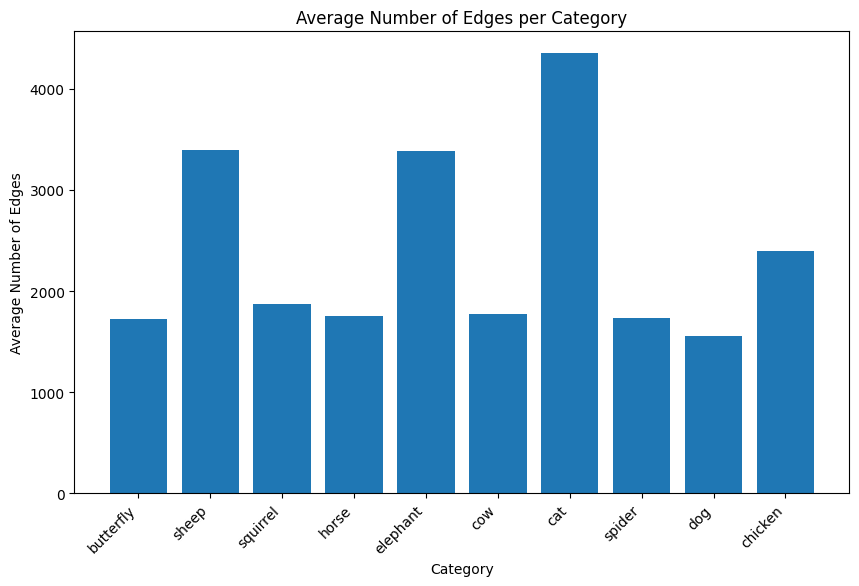

In [ ]:
# Extract the categories and the average number of edges from the category_features dictionary
categories = list(category_features.keys())
avg_num_edges = list(category_features.values())

# Plot the bar chart
plt.figure(figsize=(10, 6))  # set figure size
plt.bar(categories, avg_num_edges)
plt.title("Average Number of Edges per Category")
plt.xlabel("Category")
plt.ylabel("Average Number of Edges")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.show()

There seem to be 2 categories with a high number of edges, 1 with a medium number, and the rest with a low number. A high number of edges means that the instances in the cat category have have more complex and detailed shapes compared to the other animals in their respective categories.

### **Image Blurriness**

References: https://stackoverflow.com/questions/57233870/blur-detection-of-image-using-opencv & https://pysource.com/2019/09/03/detect-when-an-image-is-blurry-opencv-with-python/


Checking if the pictures are blurry:

Blurriness in images refers to the loss of sharpness or detail in an image. It can be caused by various factors, such as camera shake, motion blur, incorrect focus, or low resolution. Blurry images can be difficult to interpret, and the information contained within them can be lost or obscured.



An empty list blurry_images is created to store the file paths of blurry images, and an empty dictionary lap_var_dict is created to store the Laplacian variance values for each image.

The code loops through each category folder in the dataset using os.listdir(path_to_dataset) to get the list of folder names.

For each category folder, an empty list file_names is created to store the names of image files in that folder.

The code then loops through each file in the category folder and checks if it is a JPEG or JPG image using the .lower().endswith(('jpeg', 'jpg')) condition.

If the file is identified as a JPEG or JPG image, its name is appended to the file_names list.

For each image in the file_names list, the code reads the image using cv2.imread() from the OpenCV library, and resizes it to a fixed size of (140, 100) using cv2.resize().

The image is then converted to grayscale using cv2.cvtColor().

The Laplacian variance of the grayscale image is calculated using cv2.Laplacian() with cv2.CV_64F data type, which is a measure of the sharpness of the image.

A threshold value of 550 is set, below which an image is considered blurry.

The code checks if the calculated Laplacian variance of the image is below the threshold, indicating that the image is blurry. If so, the image path is added to the blurry_images list, and the Laplacian variance value is added to the lap_var_dict dictionary with the image path as the key.

After processing all the images in the category folder, the code sorts the lap_var_dict dictionary by Laplacian variance in descending order using sorted() function with a lambda function as the key, which allows sorting by the values.

The top 25 blurry images are selected from the sorted dictionary by taking the first 49 items (file paths) using a list comprehension, and stored in the top_25_blurry_images list.

The code prints the total number of blurry images detected, which is the length of the blurry_images list.


The threshold was decided by iteration and seeing if the 25 less blurry images were still visually blurry or not.

In [ ]:
# create an empty list to store the blurry image file paths
blurry_images = []
lap_var_dict = {}

# loop through each category folder
for folder in os.listdir(path_to_dataset):
    # create an empty list to store the file names
    file_names = []
    
    # loop through each file in the folder
    for file in os.listdir(os.path.join(path_to_dataset, folder)):
        # check if the file is a JPEG or JPG image
        if file.lower().endswith(('jpeg', 'jpg')):
            # add the file name to the list
            file_names.append(file)
        
    # calculate the sharpness of each image using Laplacian filter
    for file_name in file_names:
        # read the image
        img = cv2.imread(os.path.join(path_to_dataset, folder, file_name))
        
        # resize the image to (140, 100)
        img = cv2.resize(img, (140, 100))
        
        # convert the image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # calculate the Laplacian variance as a measure of image sharpness
        lap_var = cv2.Laplacian(gray, cv2.CV_64F).var()
        #print(lap_var)
        
        # set a threshold value for the variance below which the image is considered blurry
        threshold = 550
        
        # check if the image is blurry or not
        if lap_var < threshold:
            # add the image path to the list of blurry images
            blurry_images.append(os.path.join(path_to_dataset, folder, file_name))
            # add the lap_var value to the dictionary
            lap_var_dict[os.path.join(path_to_dataset, folder, file_name)] = lap_var

# sort the dictionary by lap_var in descending order
sorted_dict = sorted(lap_var_dict.items(), key=lambda x: x[1], reverse=True)

# select the top 25 images
top_25_blurry_images = [x[0] for x in sorted_dict[:49]]

print('Number of blurry images:',len(blurry_images))


Number of blurry images: 333


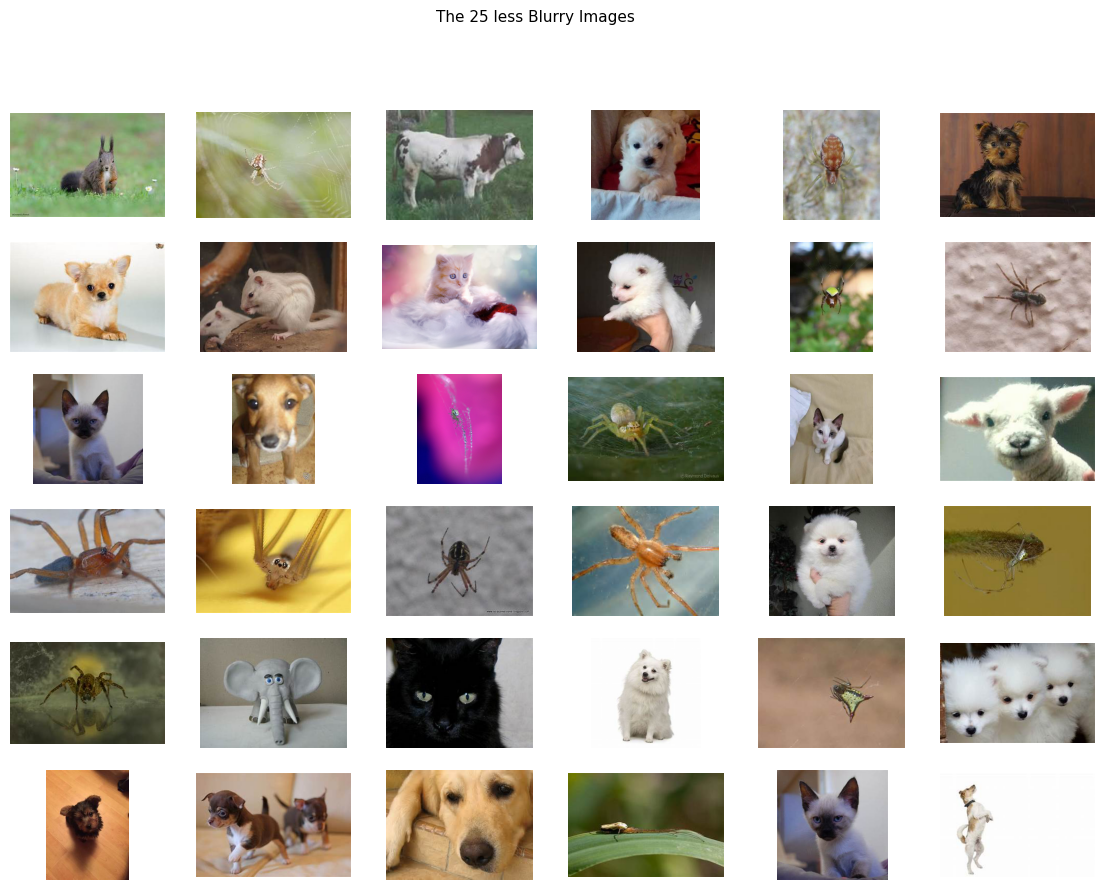

In [ ]:
# create a 5x5 subplot grid
fig, ax = plt.subplots(6, 6, figsize=(14,10))
fig.suptitle('The 25 less Blurry Images', fontsize=11)
# loop through the top 25 blurry images
for i in range(36):
    # load the image
    img = mpimg.imread(top_25_blurry_images[i])
    # get the row and column index for the subplot
    row = i // 6
    col = i % 6
    # plot the image in the corresponding subplot
    ax[row][col].imshow(img)
    ax[row][col].axis('off')

plt.show()


### **Images Noise**

Noise in an image refers to random variations of brightness or color information that are not part of the original image. These variations can be caused by several factors, including imperfect camera sensors, high ISO settings, low light conditions, and data compression. Noise can be visible as grainy or speckled patterns in the image, and can reduce the clarity and quality of the image.


An empty list "noisy_files" is created to store the file names and their mean amplitudes of noisy images.

The code loops through each category folder in the training folder using "os.listdir(path_to_dataset)".

For each category folder, an empty list "file_names" is created to store the file names and their corresponding image arrays. Another set "added_file_names" is created to keep track of the file names that have already been added to the list.

The code loops through each file in the category folder and checks if the file is a JPEG image and has three color channels. If the conditions are met, the script resizes the image to (140, 100), and then adds the file name and image to "file_names" and "added_file_names", respectively.

The code then calculates the noise level of each image in "file_names" using Fast Fourier Transform. 
For each image, the code converts the image to grayscale, applies a Fast Fourier Transform to the image, calculates the amplitude spectrum of the Fourier Transform, sets a threshold value for the mean amplitude below which the image is considered noisy, calculates the mean amplitude of the Fourier Transform, and checks if the image is noisy or not. If the mean amplitude of the image is below the threshold, the code adds the file name, image, and mean amplitude to "noisy_files".

The threshold defined is 129 and was changed iteratively untill its final value.

After processing all images in all category folders, the script sorts "noisy_files" by mean amplitude in descending order using "noisy_files.sort(key=lambda x: x[2], reverse=True)".

The script takes the top 49 files with the highest mean amplitude using "top_noisy_files = noisy_files[:49]".

The script prints the number of noisy images identified using "print('Number of noisy images:',len(noisy_files) )".

Check for noise:

In [ ]:
# Set the main folder path
path_to_dataset = path + training_folder

# create an empty list to store the noisy file names and their mean amplitudes
noisy_files = []

# loop through each category folder
for folder in os.listdir(path_to_dataset):
    # create an empty list to store the file names
    file_names = []
    # create a set to store the image file names that have been added to the list
    added_file_names = set()
    
    # loop through each file in the folder
    for file in os.listdir(os.path.join(path_to_dataset, folder)):
        # check if the file is a JPEG image and has three color channels
        if file.endswith('.jpeg') or file.endswith('.jpg'):
            file_path = os.path.join(path_to_dataset, folder, file)
            # check if the file name already exists in the list
            if file not in added_file_names:
                img = cv2.imread(file_path)
                if img is not None and img.shape[2] == 3:
                    # resize the image to (140, 100)
                    img = cv2.resize(img, (140, 100))
                    # add the file name and image to the list and set
                    file_names.append((file_path, img))
                    added_file_names.add(file)
        
    # calculate the noise level of each image using Fast Fourier Transform
    for file_name, img in file_names:
        # convert the image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # apply a Fast Fourier Transform to the image
        f = np.fft.fft2(gray)
        fshift = np.fft.fftshift(f)
        
        # calculate the amplitude spectrum of the Fourier Transform
        magnitude_spectrum = 20*np.log(np.abs(fshift))
        
        # set a threshold value for the mean amplitude below which the image is considered noisy
        threshold = 129
        
        # calculate the mean amplitude of the Fourier Transform
        mean_amplitude = np.mean(magnitude_spectrum)
        
        # check if the image is noisy or not
        if mean_amplitude < threshold:
            img_path = os.path.join(path_to_dataset, file_name)
            noisy_files.append((file_name, img, mean_amplitude))

# sort the noisy files list by mean amplitude in descending order
noisy_files.sort(key=lambda x: x[2], reverse=True)

# take the top 25 files with the highest mean amplitude
top_noisy_files = noisy_files[:49]

print('Number of noisy images:',len(noisy_files) )


Number of noisy images: 386


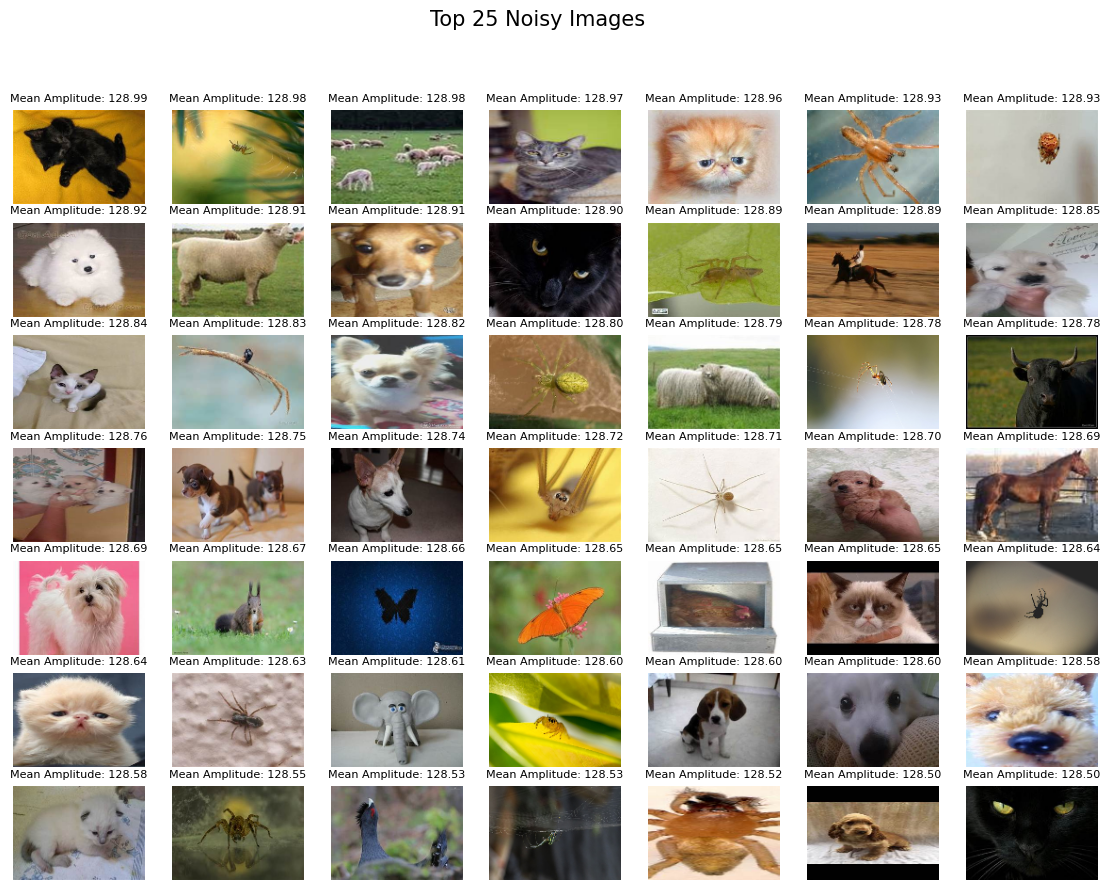

In [ ]:
# create a 5x5 grid to show the images
fig, axs = plt.subplots(7, 7, figsize=(14, 10))
fig.suptitle('Top 25 Noisy Images', fontsize=15)

# loop through each top noisy file and show it in the grid
for i, (file_name, img, mean_amplitude) in enumerate(top_noisy_files):
    # get the subplot location in the grid
    row = i // 7
    col = i % 7
    
    # resize the image to (140, 100)
    img_resized = cv2.resize(img, (140, 100))
    
    # show the image in the subplot
    axs[row, col].imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
    axs[row, col].set_title(f'Mean Amplitude: {mean_amplitude:.2f}', fontsize=8)
    axs[row, col].axis('off')

plt.show()


By zooming in the quality of the images is clearly lacking.

### **Conclusion**

Although the usability of the dataset is rated as a 10 on kaggle the dataset is not the best quality, it has more than 300 images that were deemed blurry and noisy by the group.
The dataset consists of images with varying number of animals, size and color of animals, where the animals are in the images, and the animals are from different perspectives.

There are too many images to do visual inspection of the dataset, but there were some nonsensical images included in the dataset such as animals dressed in costumes, animals drawn/tattooed, dolls of animals and even 1 image of socks.

In the data processing the images that are not JPEG and RGB will be deleted. The blurry and noisy images will be too.

In order to identify outliers the following methods will be tried: Isolation forest, and z-score.
These methods are generally applicable to any type of image dataset, however, their effectiveness is affected by the complexity and variability of the images.

In general, these methods can be useful for identifying outliers or anomalies in datasets with a large number of images, especially if the images are highly variable or noisy. For example, these methods can be applied to identify mislabeled or low-quality images, or to identify rare or unusual examples within a large and diverse dataset.  However, considering the high variablity of the dataset, each method output will be carefully evaluated to see if it's idetifying reasonable images as outliers.

Data augmentation will also be performed to balance in a way that balances the dataset.
